In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib import cm

import numpy as np
import pickle
import os
import pandas as pd
import joypy

from utilities.dataset import distribution_data_sampler
from utilities import constants, dataset

import scipy.stats as stats

from utilities.custom_layers import BaseEncoder, BaseDecoder, PreprocessingWrapper
from utilities import funcs

n_samples = 10000
# import scienceplots

# plt.style.use('science')

2023-04-27 13:00:20.376125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [34]:
with open("only_inputs_results.pkl", "rb") as file:
    data = pickle.load(file)

for idx, inp in enumerate(data):
    cur_history = data[idx]['history']
    cur_history['loss'] = np.pad(np.array(cur_history['loss']), (0, 1000 - len(cur_history['loss'])), 'edge') 
    cur_history['val_loss'] = np.pad(np.array(cur_history['val_loss']), (0, 1000 - len(cur_history['val_loss'])), 'edge') 
    data[idx]['history'] = cur_history
    
df = pd.json_normalize(data, max_level=0)
df['duplication'] = df['duplication'].replace({1:False, 32:True})

#  Tables

In [35]:
total_number_transformations = df.shape[0]/(df['seed'].nunique() * df['x'].nunique())

pd.options.display.max_rows = int(total_number_transformations)

results = df.groupby('params_id')[['score_noised_within', 'score_noised_beyond', 'score_pure_within', 'score_pure_beyond']].mean()
results = results.rename({'score_noised_within': 'loss_noised_within', 'score_noised_beyond': 'loss_noised_beyond', 'score_pure_within': 'loss_pure_within', 'score_pure_beyond':'loss_pure_beyond'}, axis=1)
results['x'] = df.groupby('params_id')[['x']].nth(0)

In [4]:
arr = ['noised_within', 'noised_beyond', 'pure_within', 'pure_beyond']
for loss in ['noised_within', 'noised_beyond', 'pure_within', 'pure_beyond']:
    best = results.groupby('x')[[f'loss_{loss}']].min()
    results[f'relative_{loss}'] = results.apply(lambda x: (x[f'loss_{loss}']/best.loc[x['x']])-1, axis=1)
    
total_results = results.groupby(results.index % total_number_transformations).mean()

transformation_description_short = df[df['params_id'] < total_number_transformations].groupby('params_id')[['transformation_name', 'transformation_params', 'keep_origin', 'duplication']].nth(0)
transformation_description_full = df.groupby('params_id')[['transformation_name', 'transformation_params', 'keep_origin', 'duplication']].nth(0)

total_results = transformation_description_short.join(total_results)

In [16]:
arr = ['noised_within', 'noised_beyond', 'pure_within', 'pure_beyond']

rel_arr = ['relative_' + x for x in arr]
total_results['relative_mean'] = total_results[rel_arr].mean(axis=1)

total_results['relative_beyond_mean'] = total_results[['relative_noised_beyond', 'relative_pure_beyond']].mean(axis=1)
total_results['relative_within_mean'] = total_results[['relative_noised_within', 'relative_pure_within']].mean(axis=1)

total_results['relative_noised_mean'] = total_results[['relative_noised_beyond', 'relative_noised_within']].mean(axis=1)
total_results['relative_pure_mean'] = total_results[['relative_pure_beyond', 'relative_pure_within']].mean(axis=1)

In [16]:
total_results[['transformation_name', 'transformation_params', 'keep_origin', 'duplication', 'relative_mean']].sort_values('relative_mean')

,transformation_name,transformation_params,keep_origin,duplication,relative_mean
params_id,,,,,
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,2.005020e-01
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,2.533371e-01
32.0,numerical_encoding,"{'base': 2, 'norm': False}",False,False,1.372225e+00
36.0,numerical_encoding,"{'base': 3, 'norm': True}",False,False,1.779120e+00
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,1.865230e+00
34.0,numerical_encoding,"{'base': 3, 'norm': False}",False,False,1.891720e+00
3.0,standardization,{},False,True,1.973993e+00
18.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,False,2.012022e+00
64.0,numerical_encoding,"{'base': 32, 'norm': True}",False,False,2.171358e+00


In [95]:
total_results[['transformation_name', 'transformation_params', 'keep_origin', 'duplication', 'relative_pure_mean']].sort_values('relative_pure_mean').head(20)

,transformation_name,transformation_params,keep_origin,duplication,relative_pure_mean
params_id,,,,,
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,0.351339
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,0.459836
32.0,numerical_encoding,"{'base': 2, 'norm': False}",False,False,2.557884
36.0,numerical_encoding,"{'base': 3, 'norm': True}",False,False,3.309602
34.0,numerical_encoding,"{'base': 3, 'norm': False}",False,False,3.446981
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,3.512857
3.0,standardization,{},False,True,3.664006
18.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,False,3.767898
64.0,numerical_encoding,"{'base': 32, 'norm': True}",False,False,4.051853


In [96]:
total_results[['transformation_name', 'transformation_params', 'keep_origin', 'duplication', 'relative_pure_beyond']].sort_values('relative_pure_beyond').head(20)

,transformation_name,transformation_params,keep_origin,duplication,relative_pure_beyond
params_id,,,,,
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,0.384869
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,0.399257
58.0,numerical_encoding,"{'base': 24, 'norm': False}",False,False,0.547152
60.0,numerical_encoding,"{'base': 24, 'norm': True}",False,False,0.903536
23.0,min_max_scaler,{},False,True,1.026160
22.0,min_max_scaler,{},False,False,1.070056
15.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,True,1.091695
40.0,numerical_encoding,"{'base': 4, 'norm': True}",False,False,1.097524
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,1.137732


In [25]:
total_results.sort_values('relative_noised_beyond')

,transformation_name,transformation_params,keep_origin,duplication,loss_noised_within,loss_noised_beyond,loss_pure_within,loss_pure_beyond,relative_noised_within,relative_noised_beyond,relative_pure_within,relative_pure_beyond,relative_mean,relative_beyond_mean,relative_within_mean,relative_noised_mean,relative_pure_mean
params_id,,,,,,,,,,,,,,,,,
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,1.210698e+00,1.377489e+00,2.101958e-01,4.358629e-01,2.171629e-02,7.195937e-02,5.348044e-01,3.848685e-01,2.533371e-01,2.284139e-01,2.782603e-01,4.683783e-02,4.598364e-01
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,1.203417e+00,1.391818e+00,2.007186e-01,4.411405e-01,1.466452e-02,8.466542e-02,3.034209e-01,3.992573e-01,2.005020e-01,2.419614e-01,1.590427e-01,4.966497e-02,3.513391e-01
58.0,numerical_encoding,"{'base': 24, 'norm': False}",False,False,1.412728e+00,1.417490e+00,4.149989e-01,4.633479e-01,2.196586e-01,1.151979e-01,9.104659e+00,5.471519e-01,2.496667e+00,3.311749e-01,4.662159e+00,1.674283e-01,4.825906e+00
60.0,numerical_encoding,"{'base': 24, 'norm': True}",False,False,1.432206e+00,1.503524e+00,4.316386e-01,5.326866e-01,2.392440e-01,1.873192e-01,9.661793e+00,9.035358e-01,2.747973e+00,5.454275e-01,4.950519e+00,2.132816e-01,5.282664e+00
40.0,numerical_encoding,"{'base': 4, 'norm': True}",False,False,1.460970e+00,1.510115e+00,4.552491e-01,5.347358e-01,2.673887e-01,1.929145e-01,9.804852e+00,1.097524e+00,2.840670e+00,6.452194e-01,5.036120e+00,2.301516e-01,5.451188e+00
23.0,min_max_scaler,{},False,True,1.482283e+00,1.524992e+00,4.773222e-01,5.304390e-01,2.886375e-01,2.058454e-01,1.113033e+01,1.026160e+00,3.162744e+00,6.160029e-01,5.709485e+00,2.472415e-01,6.078247e+00
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,1.416090e+00,1.532979e+00,4.091484e-01,5.403292e-01,2.224476e-01,2.127586e-01,5.887982e+00,1.137732e+00,1.865230e+00,6.752455e-01,3.055215e+00,2.176031e-01,3.512857e+00
22.0,min_max_scaler,{},False,False,1.489101e+00,1.535004e+00,4.825401e-01,5.303599e-01,2.952937e-01,2.144234e-01,1.134012e+01,1.070056e+00,3.229972e+00,6.422397e-01,5.817705e+00,2.548586e-01,6.205086e+00
15.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,True,1.456870e+00,1.534960e+00,4.492072e-01,5.379106e-01,2.640126e-01,2.161175e-01,1.054602e+01,1.091695e+00,3.029461e+00,6.539060e-01,5.405016e+00,2.400650e-01,5.818857e+00


In [26]:
total_results.sort_values('relative_pure_within')

,transformation_name,transformation_params,keep_origin,duplication,loss_noised_within,loss_noised_beyond,loss_pure_within,loss_pure_beyond,relative_noised_within,relative_noised_beyond,relative_pure_within,relative_pure_beyond,relative_mean,relative_beyond_mean,relative_within_mean,relative_noised_mean,relative_pure_mean
params_id,,,,,,,,,,,,,,,,,
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,1.203417e+00,1.391818e+00,2.007186e-01,4.411405e-01,1.466452e-02,8.466542e-02,3.034209e-01,3.992573e-01,2.005020e-01,2.419614e-01,1.590427e-01,4.966497e-02,3.513391e-01
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,1.210698e+00,1.377489e+00,2.101958e-01,4.358629e-01,2.171629e-02,7.195937e-02,5.348044e-01,3.848685e-01,2.533371e-01,2.284139e-01,2.782603e-01,4.683783e-02,4.598364e-01
32.0,numerical_encoding,"{'base': 2, 'norm': False}",False,False,1.283438e+00,1.612796e+00,2.867950e-01,5.661375e-01,9.328709e-02,2.798438e-01,3.847022e+00,1.268746e+00,1.372225e+00,7.742948e-01,1.970155e+00,1.865655e-01,2.557884e+00
34.0,numerical_encoding,"{'base': 3, 'norm': False}",False,False,1.283193e+00,1.980250e+00,2.833324e-01,9.249002e-01,9.296413e-02,5.799533e-01,4.093563e+00,2.800400e+00,1.891720e+00,1.690177e+00,2.093263e+00,3.364587e-01,3.446981e+00
3.0,standardization,{},False,True,1.355207e+00,1.752279e+00,3.501203e-01,7.200561e-01,1.625678e-01,4.053921e-01,4.820888e+00,2.507125e+00,1.973993e+00,1.456259e+00,2.491728e+00,2.839799e-01,3.664006e+00
36.0,numerical_encoding,"{'base': 3, 'norm': True}",False,False,1.330459e+00,1.708389e+00,3.285641e-01,6.915705e-01,1.386558e-01,3.586207e-01,4.950082e+00,1.669122e+00,1.779120e+00,1.013871e+00,2.544369e+00,2.486383e-01,3.309602e+00
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,1.416090e+00,1.532979e+00,4.091484e-01,5.403292e-01,2.224476e-01,2.127586e-01,5.887982e+00,1.137732e+00,1.865230e+00,6.752455e-01,3.055215e+00,2.176031e-01,3.512857e+00
64.0,numerical_encoding,"{'base': 32, 'norm': True}",False,False,1.407035e+00,1.709895e+00,3.982968e-01,6.780307e-01,2.134568e-01,3.682696e-01,5.943763e+00,2.159943e+00,2.171358e+00,1.264106e+00,3.078610e+00,2.908632e-01,4.051853e+00
18.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,False,1.370664e+00,1.685452e+00,3.630620e-01,6.660066e-01,1.790695e-01,3.332229e-01,5.997713e+00,1.538083e+00,2.012022e+00,9.356527e-01,3.088391e+00,2.561462e-01,3.767898e+00


In [27]:
total_results.sort_values('relative_pure_beyond')

,transformation_name,transformation_params,keep_origin,duplication,loss_noised_within,loss_noised_beyond,loss_pure_within,loss_pure_beyond,relative_noised_within,relative_noised_beyond,relative_pure_within,relative_pure_beyond,relative_mean,relative_beyond_mean,relative_within_mean,relative_noised_mean,relative_pure_mean
params_id,,,,,,,,,,,,,,,,,
26.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'uniform'}",False,False,1.210698e+00,1.377489e+00,2.101958e-01,4.358629e-01,2.171629e-02,7.195937e-02,5.348044e-01,3.848685e-01,2.533371e-01,2.284139e-01,2.782603e-01,4.683783e-02,4.598364e-01
30.0,k_bins_discr,"{'n_bins': 32, 'strategy': 'kmeans'}",False,False,1.203417e+00,1.391818e+00,2.007186e-01,4.411405e-01,1.466452e-02,8.466542e-02,3.034209e-01,3.992573e-01,2.005020e-01,2.419614e-01,1.590427e-01,4.966497e-02,3.513391e-01
58.0,numerical_encoding,"{'base': 24, 'norm': False}",False,False,1.412728e+00,1.417490e+00,4.149989e-01,4.633479e-01,2.196586e-01,1.151979e-01,9.104659e+00,5.471519e-01,2.496667e+00,3.311749e-01,4.662159e+00,1.674283e-01,4.825906e+00
60.0,numerical_encoding,"{'base': 24, 'norm': True}",False,False,1.432206e+00,1.503524e+00,4.316386e-01,5.326866e-01,2.392440e-01,1.873192e-01,9.661793e+00,9.035358e-01,2.747973e+00,5.454275e-01,4.950519e+00,2.132816e-01,5.282664e+00
23.0,min_max_scaler,{},False,True,1.482283e+00,1.524992e+00,4.773222e-01,5.304390e-01,2.886375e-01,2.058454e-01,1.113033e+01,1.026160e+00,3.162744e+00,6.160029e-01,5.709485e+00,2.472415e-01,6.078247e+00
22.0,min_max_scaler,{},False,False,1.489101e+00,1.535004e+00,4.825401e-01,5.303599e-01,2.952937e-01,2.144234e-01,1.134012e+01,1.070056e+00,3.229972e+00,6.422397e-01,5.817705e+00,2.548586e-01,6.205086e+00
15.0,quantilation,"{'n_quantiles': 1000, 'output_distribution': '...",False,True,1.456870e+00,1.534960e+00,4.492072e-01,5.379106e-01,2.640126e-01,2.161175e-01,1.054602e+01,1.091695e+00,3.029461e+00,6.539060e-01,5.405016e+00,2.400650e-01,5.818857e+00
40.0,numerical_encoding,"{'base': 4, 'norm': True}",False,False,1.460970e+00,1.510115e+00,4.552491e-01,5.347358e-01,2.673887e-01,1.929145e-01,9.804852e+00,1.097524e+00,2.840670e+00,6.452194e-01,5.036120e+00,2.301516e-01,5.451188e+00
6.0,yeo_johnson,"{'method': 'yeo-johnson', 'standardize': False}",False,False,1.416090e+00,1.532979e+00,4.091484e-01,5.403292e-01,2.224476e-01,2.127586e-01,5.887982e+00,1.137732e+00,1.865230e+00,6.752455e-01,3.055215e+00,2.176031e-01,3.512857e+00


# Distributions

In [2]:
df = dataset.load_toy_dataset(path='./datasets/synthetic/sin_y/*')
total_transformations = sum([len(v['params']) for k, v in constants.TRANSFORMATIONS.items() if k!='numerical_encoding'])
total_distributions = len(df)

In [3]:
sub_sample_transformations = {k:v for k,v in constants.TRANSFORMATIONS.items() if k!= 'numerical_encoding'}

/home/nearpit/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


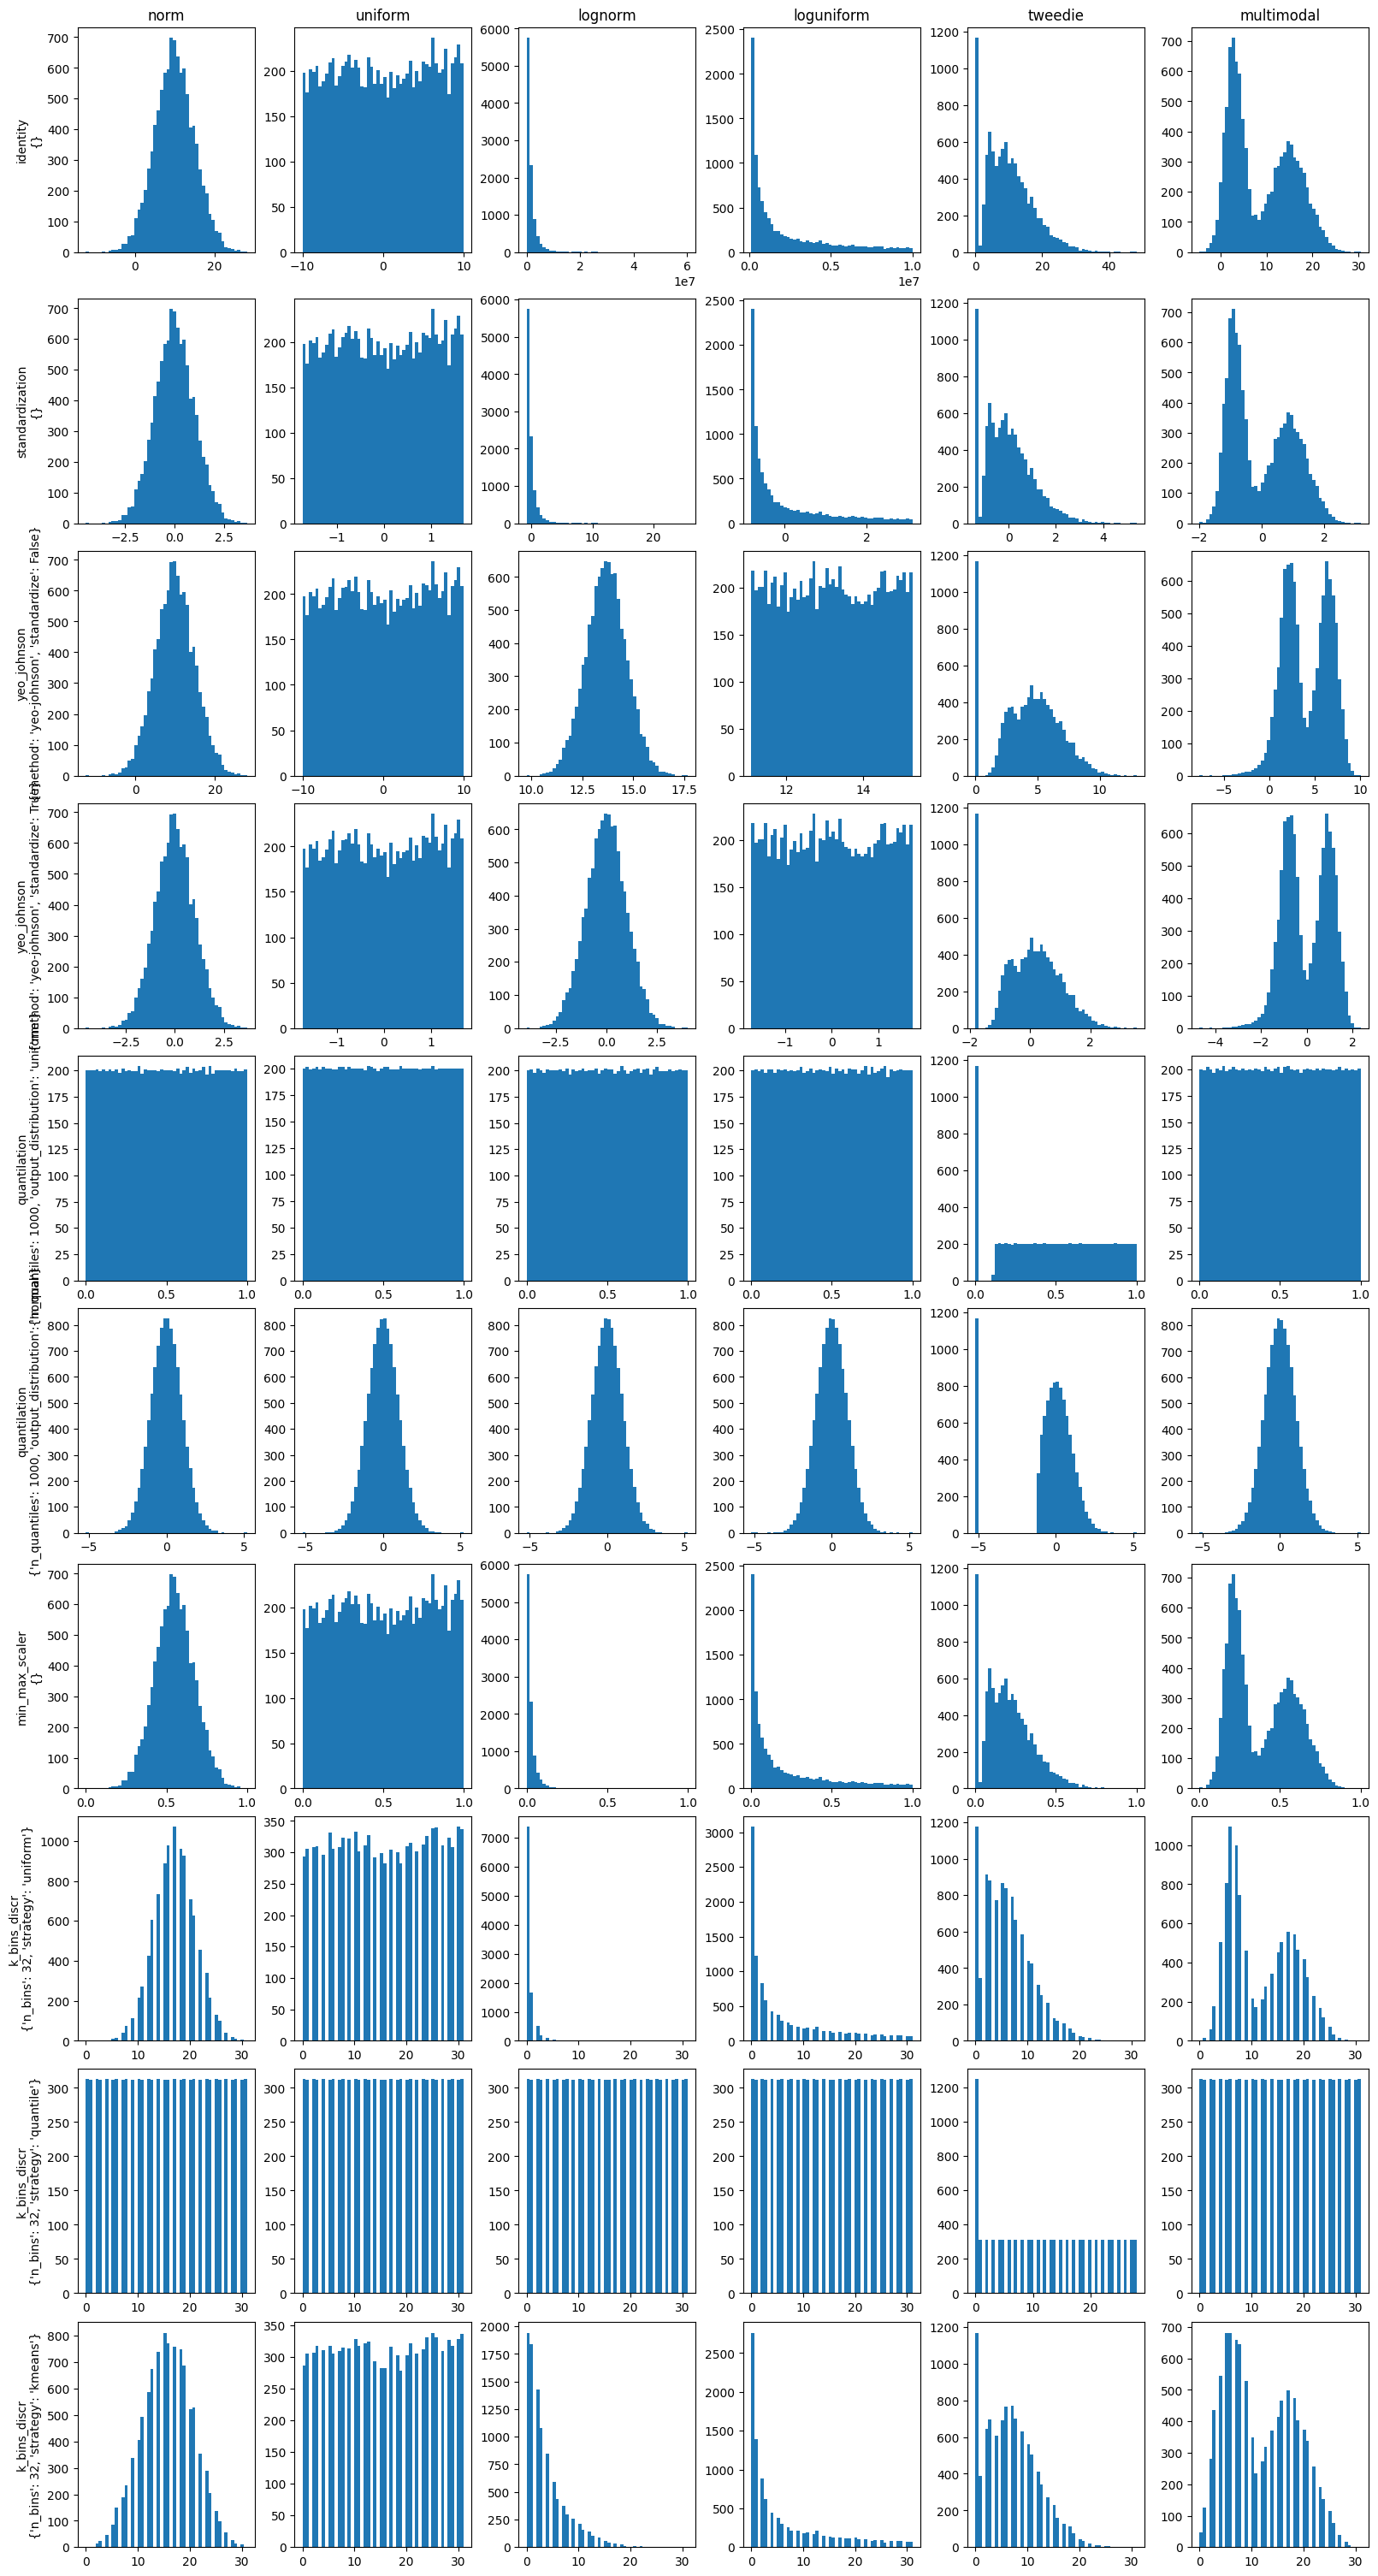

In [19]:
bins = 50
fig, ax = plt.subplots(total_transformations, total_distributions, figsize=(16, total_transformations*3), layout="constrained")
for idy, (dist_name, dist_loader) in enumerate(df.items()):
    idx = 0
    if idx == 0:
        ax[idx, idy].set_title(dist_name)
    x = dist_loader['x']
    for transformation_name, transformation_loader in sub_sample_transformations.items():
        for param in transformation_loader['params']:
            if idy == 0:
                ax[idx, idy].set_ylabel(f'{transformation_name}\n{param}')
            transformation_layer = PreprocessingWrapper(transformation_loader['preproc_layer'](**param), keep_origin=False, duplicate=False)
            transformed_x = transformation_layer(x)
            if transformation_name == 'k_bins_discr':
                transformed_x = np.argmax(transformed_x, axis=-1)
            else:
                transformed_x = np.squeeze(transformed_x, axis=-1)
            ax[idx, idy].hist(transformed_x, bins=bins)
            idx += 1

In [28]:
df = 100
shuffled_indices = np.random.choice(np.arange(df), size=df, replace=False).reshape(-1, 1)
a, b, c = np.split(shuffled_indices, [int(0.6*df), int((0.8)*df)])

In [29]:
a.shape

(60, 1)